## Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [ ]:
#Preprocessing factor - Unified unit in hands.
all_data_mkt_bond.loc[all_data_mkt_bond['bondcode'].str.startswith('11'),'vol_b']=all_data_mkt_bond.loc[all_data_mkt_bond['bondcode'].str.startswith('11'),'vol_b']*10 #单位统一为1手
mkt_bond_day=mkt_bond_day.rename(columns={'thscode':'bondcode'})


## Construct Factor

In [2]:
'''Limit-up and limit-down factor
- Do most stocks gain in the three days after a limit-up? 
- Do most stocks decline in the three days after a limit-down? '''
df=pd.read_csv('mkt_bond_ifind.csv')
df=df[~(df['volume']==0)]
dmkt=df
dmkt=dmkt.rename(columns={'thscode':'bondcode'})

dmkt['Up']=0
dmkt['Down']=0
dmkt.loc[((((dmkt['stockbond'].str.startswith('3'))|(dmkt['stockbond'].str.startswith('68')))&
           (dmkt['stockpct'].round(0)==20))|((~((dmkt['stockbond'].str.startswith('3'))|
                                              (dmkt['stockbond'].str.startswith('68'))))&(dmkt['stockpct'].round(0)==10))),'Up']=1
dmkt.loc[((((dmkt['stockbond'].str.startswith('3'))|(dmkt['stockbond'].str.startswith('68')))&
           (dmkt['stockpct'].round(1)==-20))|((~((dmkt['stockbond'].str.startswith('3'))|
                                               (dmkt['stockbond'].str.startswith('68'))))&(dmkt['stockpct'].round(1)==-10))),'Down']=1

dmkt['date']=pd.to_datetime(dmkt['date'])
dmkt=dmkt.sort_values(by='date')
dmkt=dmkt.set_index('date')

# Maximum return and maximum drawdown achievable during the holding period (next 3 days).
dmkt['3D_up']=dmkt.groupby('bondcode')['high'].transform(lambda x:x.rolling(3).max().shift(-2))
dmkt['3D_up_pct']=dmkt['3D_up']/dmkt['open'] #3d_up: max profit
dmkt['3D_down']=dmkt.groupby('bondcode')['low'].transform(lambda x:x.rolling(3).min().shift(-2))
dmkt['3D_down_pct']=dmkt['3D_down']/dmkt['open'] #3d_down: max loss


print('The all market return of all bonds: ')
print(pd.DataFrame(dmkt[['3D_up_pct','3D_down_pct']].mean()))
print('-·'*50)

print('The all market number of rising bonds: ')
print(pd.DataFrame({'Rising-bond numbers':dmkt.loc[dmkt['3D_up_pct']>1,['3D_up_pct']].count(),
                   'Rising-bond return':dmkt.loc[dmkt['3D_up_pct']>1,['3D_up_pct']].mean()}))
print()
print('The all market number of going-down bonds: ')
print(pd.DataFrame({'Going-down-bond numbers':dmkt.loc[dmkt['3D_up_pct']<=1,['3D_up_pct']].count(),
                   'Going-down-bond return':dmkt.loc[dmkt['3D_up_pct']<=1,['3D_up_pct']].mean()}))
print('-·'*50)


dmkt['pro_up']=0 #Limit up -> 1
dmkt['pro_down']=0
dmkt.loc[dmkt.groupby('bondcode')['Up'].shift(1)==1,'pro_up']=1
dmkt.loc[dmkt.groupby('bondcode')['Down'].shift(1)==1,'pro_down']=1
dmkt['prev_close']=dmkt.groupby('bondcode')['close'].transform(lambda x: x.shift(1))
dmkt['after_close']=dmkt.groupby('bondcode')['close'].transform(lambda x: x.shift(-1))
dmkt['2D_close']=dmkt.groupby('bondcode')['close'].transform(lambda x: x.shift(-2))
dmkt['3D_close']=dmkt.groupby('bondcode')['close'].transform(lambda x: x.shift(-3))

dmkt['after_open']=dmkt.groupby('bondcode')['open'].transform(lambda x: x.shift(-1))
dmkt['2D_open']=dmkt.groupby('bondcode')['open'].transform(lambda x: x.shift(-2))
dmkt['3D_open']=dmkt.groupby('bondcode')['open'].transform(lambda x: x.shift(-3))

dt_D_Up=dmkt.loc[dmkt['pro_up']==1,['bondcode','open','high','low','close',
                                                   'changeRatio','3D_up','3D_up_pct','3D_down','3D_down_pct']]
dt_D_Down=dmkt.loc[dmkt['pro_down']==1,['bondcode','open','high','low','close',
                                                   'changeRatio','3D_up','3D_up_pct','3D_down','3D_down_pct']]
print('The average return 3 days after Limit Up is: ')
print(pd.DataFrame(dt_D_Up.groupby('bondcode')[['3D_up_pct','3D_down_pct']].mean()).head(10))
print('-·'*50)
print('The average return 3 days after Limit Down is: ')
print(pd.DataFrame(dt_D_Down.groupby('bondcode')[['3D_up_pct','3D_down_pct']].mean()).head(10))


The all market return of all bonds: 
                    0
3D_up_pct    1.024855
3D_down_pct  0.981432
-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·
The all market number of rising bonds: 
           Rising-bond numbers  Rising-bond return
3D_up_pct               443627            1.025722

The all market number of going-down bonds: 
           Going-down-bond numbers  Going-down-bond return
3D_up_pct                    15460                     1.0
-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·
The average return 3 days after Limit Up is: 
           3D_up_pct  3D_down_pct
bondcode                         
110034.SH   1.025691     0.987967
110038.SH   1.031983     0.934061
110039.SH   1.048157     0.953036
110040.SH   1.111342     0.983473
110041.SH   1.090816     0.928511
110042.SH   1.040012     0.977090
110043.SH   1.062939     0.952977
110044.SH   1.083385     0.911195
1100

In [68]:
print('The all market average return 3 days after Limit Up is: ')
print(pd.DataFrame(dt_D_Up[['3D_up_pct','3D_down_pct']].mean()))
print('-·'*50)
print('The all market number of rising bonds 3 days after Limit Up is: ')
print(pd.DataFrame({'Rising-bond numbers':dt_D_Up.loc[dt_D_Up['3D_up_pct']>1,['3D_up_pct']].count(),
                   'Rising-bond return':dt_D_Up.loc[dt_D_Up['3D_up_pct']>1,['3D_up_pct']].mean()}))
print()
print('The all market number of going-down bonds 3 days after Limit Up is: ')
print(pd.DataFrame({'Going-down-bond numbers':dt_D_Up.loc[dt_D_Up['3D_up_pct']<=1,['3D_up_pct']].count(),
                   'Going-down-bond return':dt_D_Up.loc[dt_D_Up['3D_up_pct']<=1,['3D_up_pct']].mean()}))
print('-·'*50)
print('The all market average return 3 days after Limit Down is: ')
print(pd.DataFrame(dt_D_Down[['3D_up_pct','3D_down_pct']].mean()))
print('-·'*50)
print('The all market number and return of rising bonds 3 days after Limit Down is: ')
print(pd.DataFrame({'Rising-bond numbers':dt_D_Down.loc[dt_D_Down['3D_up_pct']>1,['3D_up_pct']].count(),
                   'Rising-bond return':dt_D_Down.loc[dt_D_Down['3D_up_pct']>1,['3D_up_pct']].mean()}))
print()
print('The all market number and return of going-down bonds 3 days after Limit Down is: ')
print(pd.DataFrame({'Going-down-bond numbers':dt_D_Down.loc[dt_D_Down['3D_up_pct']<=1,['3D_up_pct']].count(),
                   'Going-down-bond return':dt_D_Down.loc[dt_D_Down['3D_up_pct']<=1,['3D_up_pct']].mean()}))

The all market average return 3 days after Limit Up is: 
                    0
3D_up_pct    1.058604
3D_down_pct  0.947867
-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·
The all market number of rising bonds 3 days after Limit Up is: 
           Rising-bond numbers  Rising-bond return
3D_up_pct                 4217            1.060633

The all market number of going-down bonds 3 days after Limit Up is: 
           Going-down-bond numbers  Going-down-bond return
3D_up_pct                      146                     1.0
-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·
The all market average return 3 days after Limit Down is: 
                    0
3D_up_pct    1.057451
3D_down_pct  0.971337
-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·
The all market number and return of rising bonds 3 days after Limit Down is: 
           Risin

In [69]:
# Further filtering, if the next day is a resumption day
# Resumption determination: 1 if resumed
dt_Dk_Up=dmkt.loc[(dmkt['pro_up'].shift(1)==1)&(dmkt['Up'].shift(1)==0)&(dmkt['Down'].shift(1)==0),['bondcode','open','high','low','close',
                                                   'changeRatio','3D_up','3D_up_pct','3D_down','3D_down_pct']]
dt_Dk_Down=dmkt.loc[(dmkt['pro_down'].shift(1)==1)&(dmkt['Up'].shift(1)==0)&(dmkt['Down'].shift(1)==0),['bondcode','open','high','low','close',
                                                   'changeRatio','3D_up','3D_up_pct','3D_down','3D_down_pct']]
print('The average return 3 days after only-1-day Limit Up is: ')
print(pd.DataFrame(dt_Dk_Up.groupby('bondcode')[['3D_up_pct','3D_down_pct']].mean()).head(10))
print('-·'*50)
print('The average return 3 days after only-1-day Limit Down is: ')
print(pd.DataFrame(dt_Dk_Down.groupby('bondcode')[['3D_up_pct','3D_down_pct']].mean()).head(10))

The average return 3 days after only-1-day Limit Up is: 
           3D_up_pct  3D_down_pct
bondcode                         
110032.SH   1.021003     0.986834
110033.SH   1.012323     0.987907
110034.SH   1.003508     0.998874
110038.SH   1.008468     0.981736
110040.SH   1.017102     0.976598
110041.SH   1.015671     0.992423
110042.SH   1.029159     0.990796
110043.SH   1.016605     0.990869
110044.SH   1.012998     0.972797
110045.SH   1.006233     0.986377
-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·
The average return 3 days after only-1-day Limit Down is: 
           3D_up_pct  3D_down_pct
bondcode                         
110032.SH   1.031781     0.996586
110033.SH   1.016770     0.987198
110034.SH   1.010020     0.995187
110038.SH   1.001382     0.985438
110041.SH   1.015520     1.000000
110043.SH   1.024785     0.995632
110044.SH   1.111280     0.992647
110045.SH   1.015459     0.998540
110046.SH   1.051777     0.998196
1

In [70]:
print('The all market average return 3 days after Limit Up is: ')
print(pd.DataFrame(dt_Dk_Up[['3D_up_pct','3D_down_pct']].mean()))
print('-·'*50)
print('The all market number of rising bonds 3 days after Limit Up is: ')
print(pd.DataFrame({'Rising-bond numbers':dt_Dk_Up.loc[dt_Dk_Up['3D_up_pct']>1,['3D_up_pct']].count(),
                   'Rising-bond return':dt_Dk_Up.loc[dt_Dk_Up['3D_up_pct']>1,['3D_up_pct']].mean()}))
print()
print('The all market number of going-down bonds 3 days after Limit Up is: ')
print(pd.DataFrame({'Going-down-bond numbers':dt_Dk_Up.loc[dt_Dk_Up['3D_up_pct']<=1,['3D_up_pct']].count(),
                   'Going-down-bond return':dt_Dk_Up.loc[dt_Dk_Up['3D_up_pct']<=1,['3D_up_pct']].mean()}))
print('-·'*50)
print('The all market average return 3 days after Limit Down is: ')
print(pd.DataFrame(dt_Dk_Down[['3D_up_pct','3D_down_pct']].mean()))
print('-·'*50)
print('The all market number and return of rising bonds 3 days after Limit Down is: ')
print(pd.DataFrame({'Rising-bond numbers':dt_Dk_Down.loc[dt_Dk_Down['3D_up_pct']>1,['3D_up_pct']].count(),
                   'Rising-bond return':dt_Dk_Down.loc[dt_Dk_Down['3D_up_pct']>1,['3D_up_pct']].mean()}))
print()
print('The all market number and return of going-down bonds 3 days after Limit Down is: ')
print(pd.DataFrame({'Going-down-bond numbers':dt_Dk_Down.loc[dt_Dk_Down['3D_up_pct']<=1,['3D_up_pct']].count(),
                   'Going-down-bond return':dt_Dk_Down.loc[dt_Dk_Down['3D_up_pct']<=1,['3D_up_pct']].mean()}))

The all market average return 3 days after Limit Up is: 
                    0
3D_up_pct    1.027986
3D_down_pct  0.980918
-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·
The all market number of rising bonds 3 days after Limit Up is: 
           Rising-bond numbers  Rising-bond return
3D_up_pct                 3401            1.028899

The all market number of going-down bonds 3 days after Limit Up is: 
           Going-down-bond numbers  Going-down-bond return
3D_up_pct                      111                     1.0
-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·
The all market average return 3 days after Limit Down is: 
                    0
3D_up_pct    1.037863
3D_down_pct  0.981964
-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·
The all market number and return of rising bonds 3 days after Limit Down is: 
           Risin

In [99]:
# What is the duration of this signal?
dt_time_Up=dmkt.loc[(dmkt['pro_up'].shift(1)==1),['bondcode','open','high','low','close',
                                                   'changeRatio','3D_up','3D_up_pct','3D_down','3D_down_pct']]
dt_time_Down=dmkt.loc[(dmkt['pro_down'].shift(3)==1)&(dmkt['pro_down'].shift(1)==1)&(dmkt['pro_down'].shift(2)==1)&(dmkt['pro_down'].shift(3)==1)&(dmkt['pro_down'].shift(2)==1),['bondcode','open','high','low','close',
                                                   'changeRatio','3D_up','3D_up_pct','3D_down','3D_down_pct']]
'''
dt_time_Down=dmkt.loc[(dmkt['pro_down'].shift(1)==1),['bondcode','open','high','low','close',
                                                   'changeRatio','3D_up','3D_up_pct','3D_down','3D_down_pct']]'''

print('The all market average return 3 days after Limit Up (1 Day Delay) is: ')
print(pd.DataFrame(dt_time_Up[['3D_up_pct','3D_down_pct']].mean()))
print('-·'*50)
print('The all market number of rising bonds 3 days after Limit Up (1 Day Delay) is: ')
print(pd.DataFrame({'Rising-bond numbers':dt_time_Up.loc[dt_time_Up['3D_up_pct']>1,['3D_up_pct']].count(),
                   'Rising-bond return':dt_time_Up.loc[dt_time_Up['3D_up_pct']>1,['3D_up_pct']].mean()}))
print()
print('The all market number of going-down bonds 3 days after Limit Up (1 Day Delay) is: ')
print(pd.DataFrame({'Going-down-bond numbers':dt_time_Up.loc[dt_time_Up['3D_up_pct']<=1,['3D_up_pct']].count(),
                   'Going-down-bond return':dt_time_Up.loc[dt_time_Up['3D_up_pct']<=1,['3D_up_pct']].mean()}))
print('-·'*50)
print('The all market average return 3 days after Limit Down (3 Day Consecutive Down) is: ')
print(pd.DataFrame(dt_time_Down[['3D_up_pct','3D_down_pct']].mean()))
print('-·'*50)
print('The all market number and return of rising bonds 3 days after Limit Down (3 Day Consecutive Down) is: ')
print(pd.DataFrame({'Rising-bond numbers':dt_time_Down.loc[dt_time_Down['3D_up_pct']>1,['3D_up_pct']].count(),
                   'Rising-bond return':dt_time_Down.loc[dt_time_Down['3D_up_pct']>1,['3D_up_pct']].mean()}))
print()
print('The all market number and return of going-down bonds 3 days after Limit Down (3 Day Consecutive Down) is: ')
print(pd.DataFrame({'Going-down-bond numbers':dt_time_Down.loc[dt_time_Down['3D_up_pct']<=1,['3D_up_pct']].count(),
                   'Going-down-bond return':dt_time_Down.loc[dt_time_Down['3D_up_pct']<=1,['3D_up_pct']].mean()}))


The all market average return 3 days after Limit Up (1 Day Delay) is: 
                    0
3D_up_pct    1.027989
3D_down_pct  0.980947
-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·
The all market number of rising bonds 3 days after Limit Up (1 Day Delay) is: 
           Rising-bond numbers  Rising-bond return
3D_up_pct                 4230            1.028889

The all market number of going-down bonds 3 days after Limit Up (1 Day Delay) is: 
           Going-down-bond numbers  Going-down-bond return
3D_up_pct                      136                     1.0
-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·
The all market average return 3 days after Limit Down (3 Day Consecutive Down) is: 
                    0
3D_up_pct    1.078250
3D_down_pct  0.986059
-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·
The all market number and r

In [162]:
# Auxiliary strategy - If the underlying stock hits the lower limit the day before, sell immediately at the opening.
dt_SubStrat=dmkt.loc[(dmkt['pro_up']==1),['bondcode','close','prev_close','high','3D_up','after_open','2D_open','3D_open','open']]
dt_SubStrat['return']=dt_SubStrat['open']/dt_SubStrat['prev_close']
print('The average return of 1openclose/0close is: ')
print(dt_SubStrat['return'].mean())
print('The std of return of 1openclose/0close is: ')
print(dt_SubStrat['return'].std())
print('-·'*50)

dt_SubStrat['return']=dt_SubStrat['after_open']/dt_SubStrat['prev_close']
print('The average return of 2openclose/0close is: ')
print(dt_SubStrat['return'].mean())
print('The std of return of 2openlose/0close is: ')
print(dt_SubStrat['return'].std())
print('-·'*50)
dt_SubStrat['return']=dt_SubStrat['2D_open']/dt_SubStrat['prev_close']
print('The average return of 3openclose/0close is: ')
print(dt_SubStrat['return'].mean())
print('The std of return of 3openclose/0close is: ')
print(dt_SubStrat['return'].std())
print('-·'*50)
dt_SubStrat['return']=dt_SubStrat['3D_open']/dt_SubStrat['prev_close']
print('The average return of 4open/0close is: ')
print(dt_SubStrat['return'].mean())
print('The std of return of 4openclose/0close is: ')
print(dt_SubStrat['return'].std())
print('-·'*50)

print('The details of the Sub Strategy: ')

print(pd.DataFrame({'Rising-bond numbers':dt_SubStrat.loc[dt_SubStrat['return']>1,['return']].count(),
                   'Rising-bond return':dt_SubStrat.loc[dt_SubStrat['return']>1,['return']].mean()}))

print(pd.DataFrame({'Going-Down-bond numbers':dt_SubStrat.loc[dt_SubStrat['return']<1,['return']].count(),
                   'Going-Down-bond return':dt_SubStrat.loc[dt_SubStrat['return']<1,['return']].mean()}))


The average return of 1openclose/0close is: 
1.002056831776199
The std of return of 1openclose/0close is: 
0.02688891751533359
-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·
The average return of 2openclose/0close is: 
1.0122564233866111
The std of return of 2openlose/0close is: 
0.056915410500745056
-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·
The average return of 3openclose/0close is: 
1.0150880418504593
The std of return of 3openclose/0close is: 
0.06881109254104062
-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·
The average return of 4open/0close is: 
1.0233202940790689
The std of return of 4openclose/0close is: 
0.08471048976806032
-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·
The details of the Sub Strategy: 
        Rising-bond numbers  Rising-bond return
return  

In [4]:
# Win rate
dt_SubStrat=dmkt.loc[(dmkt['pro_up']==1),['bondcode','close','prev_close','high','3D_up','after_open','2D_open','3D_open','open']]
dt_SubStrat['return']=dt_SubStrat['open']/dt_SubStrat['prev_close']
w=len(dt_SubStrat[dt_SubStrat['return']>1])
l=len(dt_SubStrat)
print(w/l)

0.5101574982880621


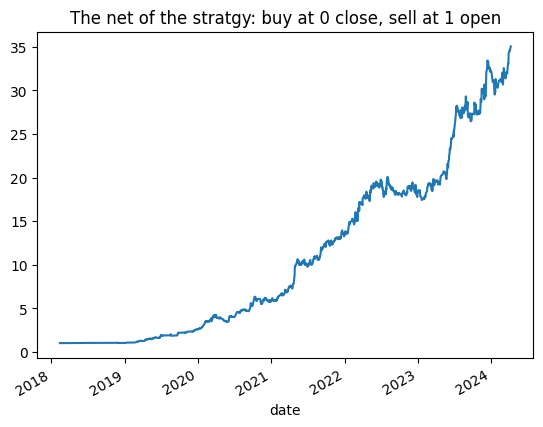

The max drawdown is:
0.19761395979228683


In [167]:
dt_SubStrat=dmkt.loc[(dmkt['pro_up']==1),['bondcode','close','prev_close','high','3D_up','after_open','2D_open','3D_open','open']]
dt_SubStrat['return']=dt_SubStrat['open']/dt_SubStrat['prev_close']
a=dt_SubStrat[~(dt_SubStrat['bondcode']=='123015.SZ')]
dt_SubStrat_ret=a.groupby(a.index)['return'].mean()
dt_SubStrat_ret=dt_SubStrat_ret.reset_index()
dt_SubStrat_ret['net']=dt_SubStrat_ret['return'].cumprod()
dt_SubStrat_ret=dt_SubStrat_ret.set_index('date')
dt_SubStrat_ret['net'].plot()
plt.title('The net of the stratgy: buy at 0 close, sell at 1 open')
plt.show()

dt_SubStrat_ret['peak'] = dt_SubStrat_ret['net'].cummax()
dt_SubStrat_ret['drawdown'] = (dt_SubStrat_ret['peak'] - dt_SubStrat_ret['net'])/dt_SubStrat_ret['peak']
dd = dt_SubStrat_ret['drawdown'].max()
print('The max drawdown is:')
print(dd)

In [106]:
# Is the highest price of the convertible bond in the 3 days after limit-up the same as that of the day after limit-up?

print('The number of bonds whose high == 3D highest:')
num1=dt_SubStrat.loc[dt_SubStrat['3D_up']==dt_SubStrat['high'],'bondcode'].count()
print(num1)
print('The number of all bonds:')
num2=dt_SubStrat['bondcode'].count()
print(num2)
print('The ratio of bonds whose high == 3D highest:')
print(num1/num2)

The number of bonds whose high == 3D highest:
2482
The number of all bonds:
4381
The ratio of bonds whose high == 3D highest:
0.566537320246519


A brief look at the df after sorted by price interval of ¥5.
        date          Bucket    amount
0 2018-01-02    [-inf, 95.0)  0.131667
1 2018-01-02   [95.0, 100.0)  0.136818
2 2018-01-02  [100.0, 105.0)  0.440000
3 2018-01-02  [105.0, 110.0)  0.646333
4 2018-01-02  [110.0, 115.0)  0.717000
5 2018-01-02  [115.0, 120.0)  0.421429
6 2018-01-02  [120.0, 125.0)       NaN
7 2018-01-02  [125.0, 130.0)  2.773000
8 2018-01-02  [130.0, 135.0)       NaN
9 2018-01-02  [135.0, 140.0)       NaN
-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·


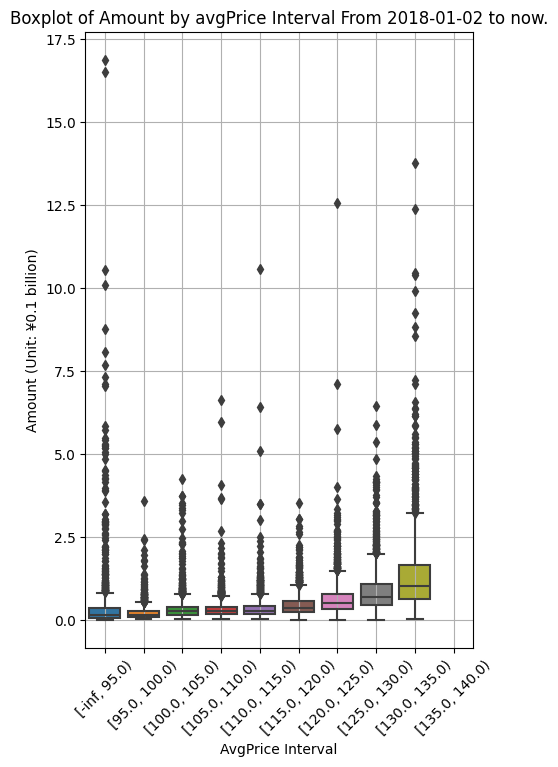

-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·


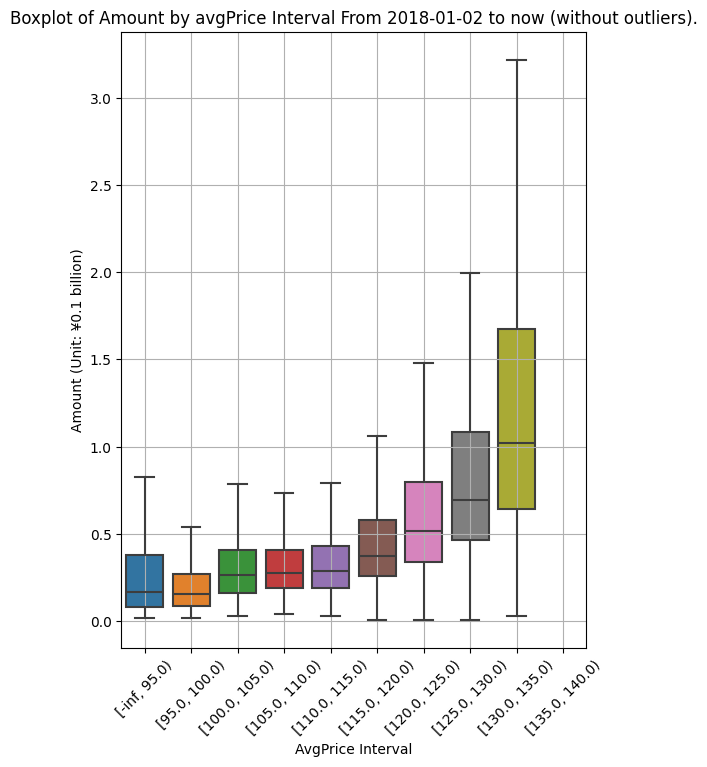

-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·


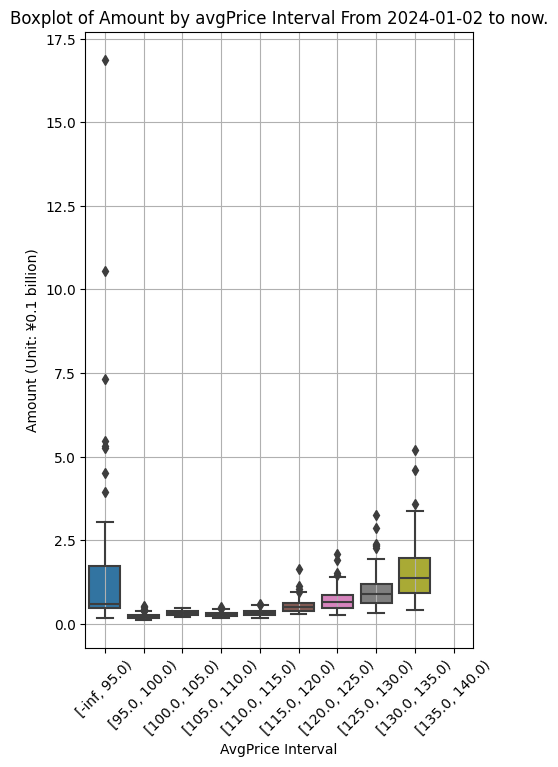

-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·


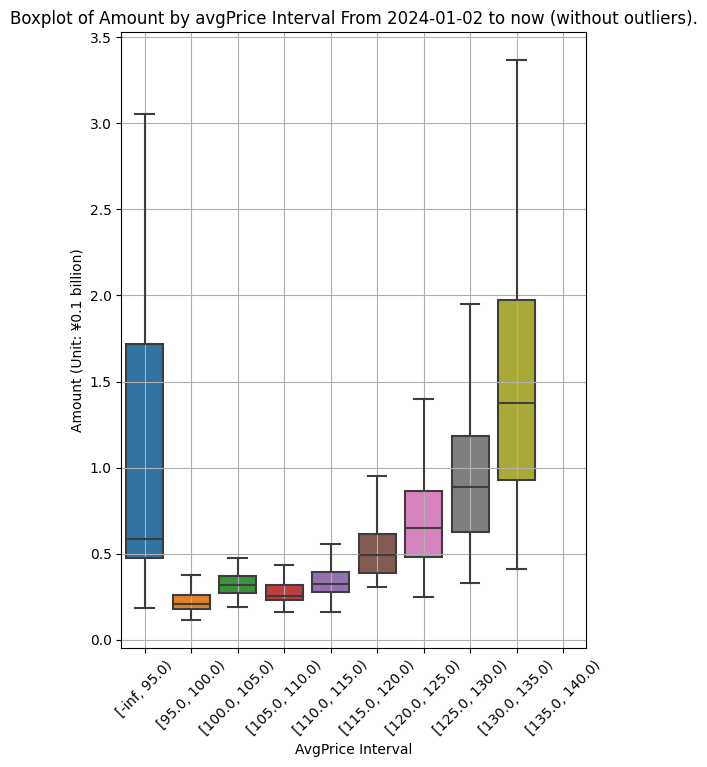

In [163]:
## Price Range

price_df=dmkt
price_df=price_df.sort_index()

# 1. First analyze the distribution

price_df['Bucket']=0
price_df=price_df[price_df['avgPrice']<=135] # Ignore >135
price_df['Bucket'] = pd.cut(price_df['avgPrice'], bins=[-float('inf')] + list(np.arange(95.00, max(price_df['avgPrice']) + 6, 5)), right=False)
price_sort_df = price_df.groupby(['date', 'Bucket'])['amount'].mean().reset_index()
print('A brief look at the df after sorted by price interval of ¥5.')
print(price_sort_df.head(10))
print('-·'*50)

import seaborn as sns

# (1) Overview of data from 2018 to present

plt.figure(figsize=(5, 8))
sns.boxplot(x='Bucket', y='amount', data=price_sort_df)
plt.xticks(rotation=45)
plt.grid()
plt.xlabel('AvgPrice Interval')
plt.ylabel('Amount (Unit: ¥0.1 billion)')
plt.title('Boxplot of Amount by avgPrice Interval From 2018-01-02 to now.')
plt.show()

print('-·'*50)

# Remove outliers and then plot
plt.figure(figsize=(6, 8))
sns.boxplot(x='Bucket', y='amount', data=price_sort_df, showfliers=False)
plt.xticks(rotation=45)
plt.grid()
plt.xlabel('AvgPrice Interval')
plt.ylabel('Amount (Unit: ¥0.1 billion)')
plt.title('Boxplot of Amount by avgPrice Interval From 2018-01-02 to now (without outliers).')
plt.show()

print('-·'*50)

# (2) Overview of data from 2024 to present

price_sort_df = price_sort_df.loc[price_sort_df['date'] >= '2024-01-02']
plt.figure(figsize=(5, 8))
sns.boxplot(x='Bucket', y='amount', data=price_sort_df)
plt.xticks(rotation=45)
plt.grid()
plt.xlabel('AvgPrice Interval')
plt.ylabel('Amount (Unit: ¥0.1 billion)')
plt.title('Boxplot of Amount by avgPrice Interval From 2024-01-02 to now.')
plt.show()

print('-·'*50)

# Remove outliers and then plot
plt.figure(figsize=(6, 8))
sns.boxplot(x='Bucket', y='amount', data=price_sort_df, showfliers=False)
plt.xticks(rotation=45)
plt.grid()
plt.xlabel('AvgPrice Interval')
plt.ylabel('Amount (Unit: ¥0.1 billion)')
plt.title('Boxplot of Amount by avgPrice Interval From 2024-01-02 to now (without outliers).')
plt.show()

A brief look at the df after sorted by price interval of ¥5.
        date          Bucket      volume
0 2018-01-02    [-inf, 95.0)   14.100000
1 2018-01-02   [95.0, 100.0)   14.145455
2 2018-01-02  [100.0, 105.0)   42.800000
3 2018-01-02  [105.0, 110.0)   60.983333
4 2018-01-02  [110.0, 115.0)   64.700000
5 2018-01-02  [115.0, 120.0)   35.814286
6 2018-01-02  [120.0, 125.0)         NaN
7 2018-01-02  [125.0, 130.0)  218.400000
8 2018-01-02  [130.0, 135.0)         NaN
9 2018-01-02  [135.0, 140.0)         NaN
-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·


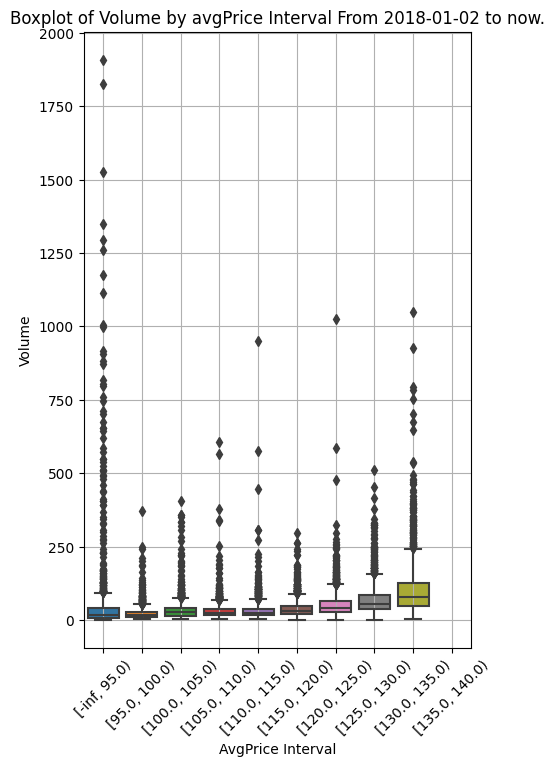

-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·


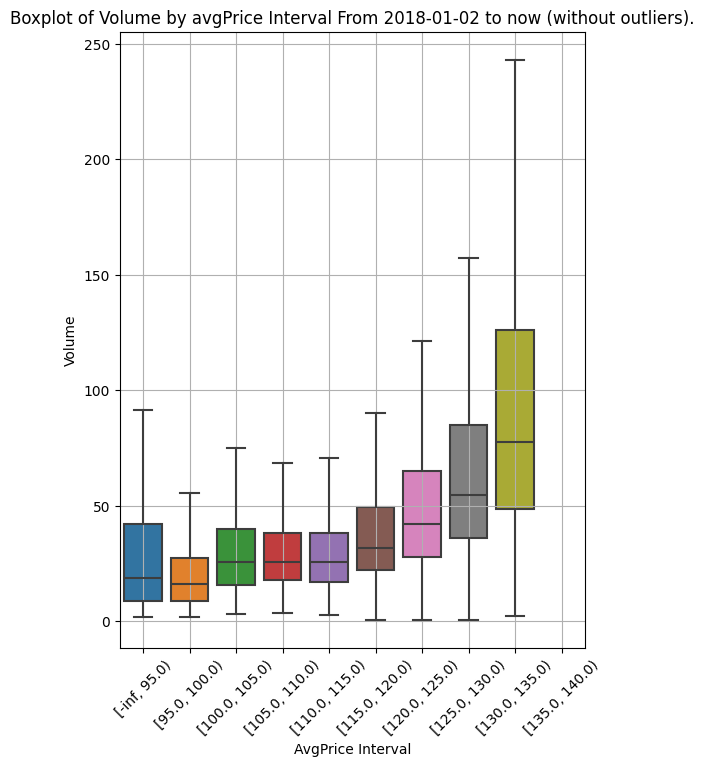

-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·


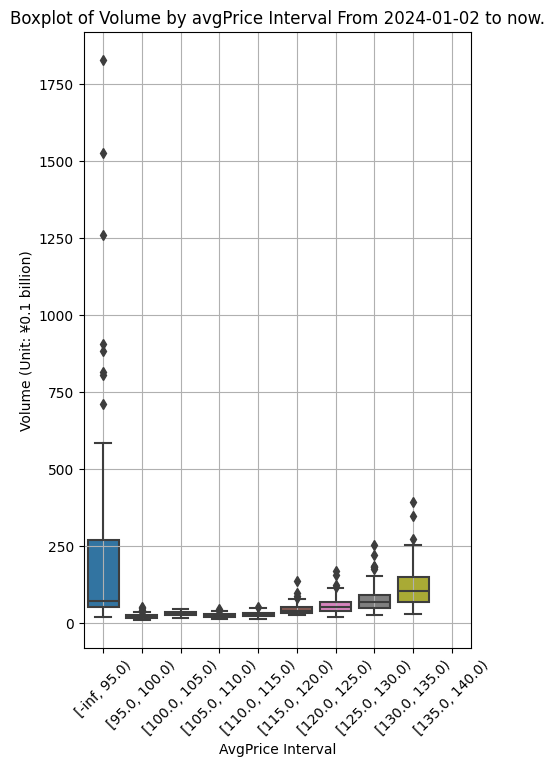

-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·-·


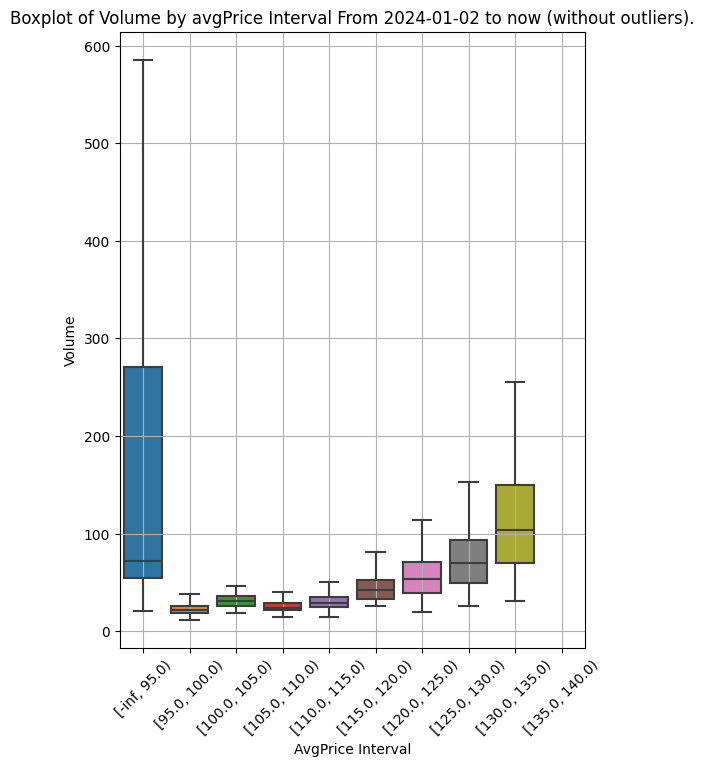

In [165]:
## Price Range - Volume Classification

price_df=dmkt
price_df=price_df.sort_index()

#1.Distribution
price_df['Bucket']=0
price_df=price_df[price_df['avgPrice']<=135]
price_df['Bucket'] = pd.cut(price_df['avgPrice'], bins=[-float('inf')] + list(np.arange(95.00, max(price_df['avgPrice']) + 6, 5)), right=False)
price_sort_df = price_df.groupby(['date', 'Bucket'])['volume'].mean().reset_index()
print('A brief look at the df after sorted by price interval of ¥5.')
print(price_sort_df.head(10))
print('-·'*50)

import seaborn as sns

# (1) Overview of data from 2018 to present
plt.figure(figsize=(5, 8))
sns.boxplot(x='Bucket', y='volume', data=price_sort_df)
plt.xticks(rotation=45)
plt.grid()
plt.xlabel('AvgPrice Interval')
plt.ylabel('Volume')
plt.title('Boxplot of Volume by avgPrice Interval From 2018-01-02 to now.')
plt.show()

print('-·'*50)

# Remove outliers and then plot
plt.figure(figsize=(6, 8))
sns.boxplot(x='Bucket', y='volume', data=price_sort_df, showfliers=False)
plt.xticks(rotation=45)
plt.grid()
plt.xlabel('AvgPrice Interval')
plt.ylabel('Volume')
plt.title('Boxplot of Volume by avgPrice Interval From 2018-01-02 to now (without outliers).')
plt.show()

print('-·'*50)

# (1) Overview of data from 2024 to present
price_sort_df = price_sort_df.loc[price_sort_df['date'] >= '2024-01-02']
plt.figure(figsize=(5, 8))
sns.boxplot(x='Bucket', y='volume', data=price_sort_df)
plt.xticks(rotation=45)
plt.grid()
plt.xlabel('AvgPrice Interval')
plt.ylabel('Volume (Unit: ¥0.1 billion)')
plt.title('Boxplot of Volume by avgPrice Interval From 2024-01-02 to now.')
plt.show()

print('-·'*50)

# Remove outliers and then plot
plt.figure(figsize=(6, 8))
sns.boxplot(x='Bucket', y='volume', data=price_sort_df, showfliers=False)
plt.xticks(rotation=45)
plt.grid()
plt.xlabel('AvgPrice Interval')
plt.ylabel('Volume')
plt.title('Boxplot of Volume by avgPrice Interval From 2024-01-02 to now (without outliers).')
plt.show()